In [1]:
import pandas as pd
import datetime

In [2]:
class feature_engine:
    
    pd = __import__('pandas')
    datetime = __import__('datetime')
    
    def __init__(self):
        print('feature_engine V.0.1 \nImported pandas,datetime packages')
        
    def calc_price_change(self,tweet_time,financial_data,time_col_name,price_col_name,interval,amount,method='both'):
        #remove seconds to match financial data format
        tweet_time=tweet_time.replace(second=0)
        #default baseline is set for five minutes before tweet
        tweet_time=tweet_time - self.datetime.timedelta(0,0,0,0,5)
        tweet_price=financial_data[financial_data[time_col_name]==tweet_time][price_col_name]
        if len(tweet_price)==0:
            return float('NaN')
        tweet_price.reset_index(inplace=True,drop=True)

        def calculation(financial_data,time_col_name,new_time,price_col_name,tweet_price,direction):
            
            other_price=financial_data[financial_data[time_col_name]==new_time][price_col_name]
            other_price.reset_index(inplace=True,drop=True)
            if len(other_price)==0:
                return float('NaN')
            elif direction=='forward':
                return ((other_price.iloc[0]/tweet_price.iloc[0])-1)
            elif direction=='backward':
                return ((tweet_price.iloc[0]/other_price.iloc[0])-1)

        if (method=='both') or (method=='forward'):  
            if interval=='minutes':
                time_forward=tweet_time + self.datetime.timedelta(0,0,0,0,amount)
            elif interval=='hours':
                time_forward=tweet_time + self.datetime.timedelta(0,0,0,0,0,amount)
            elif interval=='days':
                time_forward=tweet_time + self.datetime.timedelta(amount,0,0,0,0)
            pct_change_forward=calculation(financial_data,time_col_name,time_forward,price_col_name,tweet_price,'forward')

        if (method=='both') or (method=='backward'): 
            if interval=='minutes':
                time_backward=tweet_time - self.datetime.timedelta(0,0,0,0,amount)   
            elif interval=='hours':
                time_backward=tweet_time - self.datetime.timedelta(0,0,0,0,0,amount) 
            elif interval=='days':
                time_backward=tweet_time - self.datetime.timedelta(amount,0,0,0,0)
            pct_change_backward=calculation(financial_data,time_col_name,time_backward,price_col_name,tweet_price,'backward')
        
        if method == 'both':
            return self.pd.DataFrame({f'{amount}_{interval}_forward_pct_change':pct_change_forward,
                          f'{amount}_{interval}_backward_pct_change':pct_change_backward},index=[0])
        elif method=='backward':
            return self.pd.DataFrame({f'{amount}_{interval}_backward_pct_change':pct_change_backward},index=[0])
        elif method=='forward':
            return self.pd.DataFrame({f'{amount}_{interval}_forward_pct_change':pct_change_forward},index=[0])
        
    def create_pricechg_columns(self,twitter_data,tweet_time_col_name,financial_data,fin_time_col_name,price_col_name,
                       interval_amount_dict,method='both'):
        from tqdm import tqdm
        new_columns=self.pd.DataFrame()
        for i, row in tqdm(twitter_data.iterrows()):
            temp_df=self.pd.DataFrame()
            for interval, amount in interval_amount_dict:
                new_df=self.calc_price_change(twitter_data[tweet_time_col_name].iloc[i],financial_data,fin_time_col_name,
                                                   price_col_name,interval,amount)
                if not isinstance(new_df,float):
                    temp_df=self.pd.concat([temp_df,new_df],axis=1)
            for item in temp_df.columns:
                new_columns.at[i,item] = temp_df.loc[0,item]
        return new_columns
    
    def mean_encoding_tocolumn(self,features_df,categorical_column,target_column):
        features_df=features_df[[categorical_column,target_column]]
        grouped=features_df.groupby([categorical_column]).mean()
        features_df=features_df.merge(grouped,on=categorical_column)
        return features_df[f'{target_column}_y']
    
    def mean_encoding_todict(self,features_df,categorical_column,target_column):
        features_df=features_df[[categorical_column,target_column]]
        return features_df.groupby([categorical_column]).mean()
    
    

In [3]:
financial_data=pd.read_csv('04052009-18122019-SPYDIA-minutedata.csv',parse_dates=['DATETIME'])
twitter_data=pd.read_csv('trump_tweets_reducted_after_nlp.csv',index_col=0,parse_dates=['created_at_utc'])

In [4]:
sp500_data=financial_data[financial_data['SYM_ROOT']=='SPY']
dow_data=financial_data[financial_data['SYM_ROOT']=='DIA']

In [ ]:
feat_eng = feature_engine()

In [ ]:
tweets_finance=feat_eng.create_pricechg_columns(twitter_data,'created_at_utc',sp500_data,'DATETIME','PRICE',
                       [('minutes',1),('minutes',5),('minutes',10),('minutes',30),('hours',1),('hours',3),('hours',6)
                        ,('days',1),('days',5),('days',10),('days',30)])

In [ ]:
tweets_finance.to_csv('tweets_finance.csv',index=True)

In [7]:
import seaborn as sns; sns.set()

C:\Users\natan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\natan\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


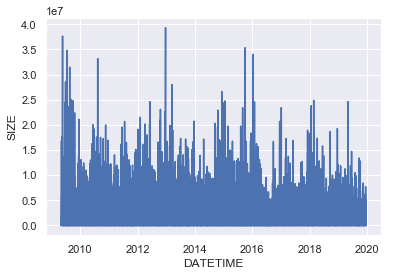

In [8]:
sns.lineplot(x="DATETIME", y="SIZE", data=sp500_data)